# # SAM2

In [1]:
import cv2, torch, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

DEV = "cuda" if torch.cuda.is_available() else "cpu"

sam = build_sam2(
        "configs/sam2.1/sam2.1_hiera_l.yaml",
        "./checkpoints/sam2.1_hiera_large.pt"
      ).to(DEV).eval()

mask_gen = SAM2AutomaticMaskGenerator(
    model=sam,
    points_per_side=48,
    pred_iou_thresh=0.70,
    stability_score_thresh=0.60,
    mask_threshold=0.60,
    box_nms_thresh=0.65,
    crop_n_layers=1,
    crop_overlap_ratio=0.2,
    min_mask_region_area=500,
    output_mode="binary_mask",
    multimask_output=True
)

추출된 마스크 개수: 5
Mask resolution: 1024 × 1024


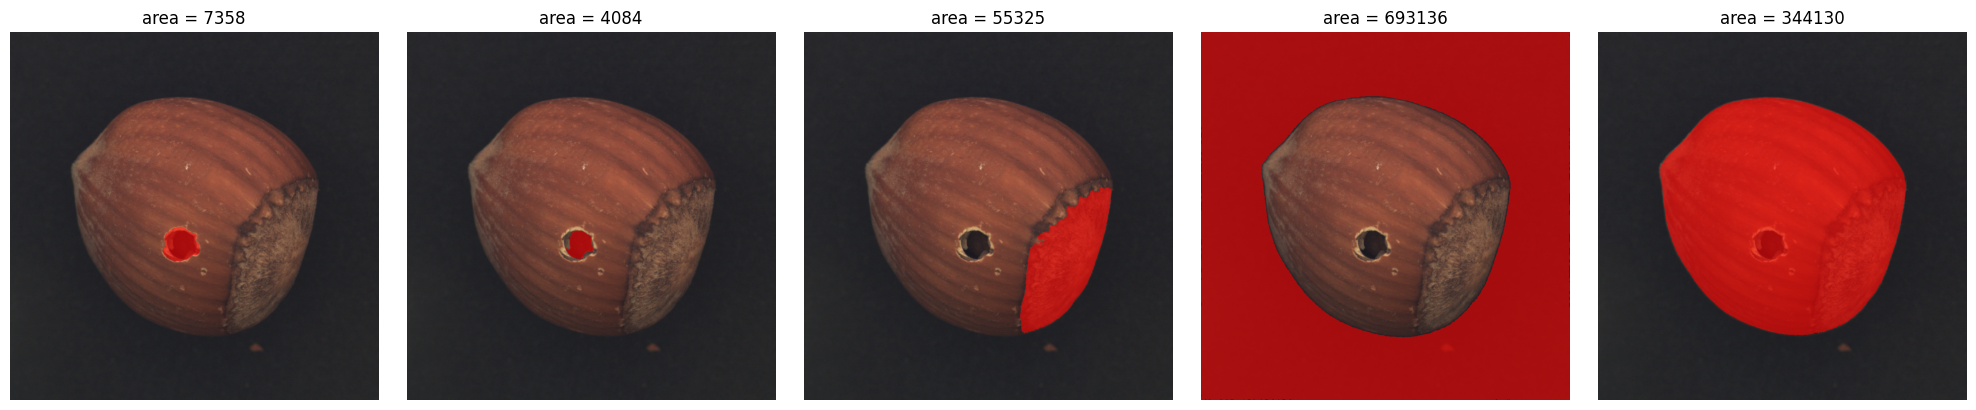

In [7]:
IMG_PATH = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole/003.png")

bgr = cv2.imread(str(IMG_PATH))
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
masks = mask_gen.generate(rgb)
print(f"추출된 마스크 개수: {len(masks)}")

if masks:
    h, w = masks[0]["segmentation"].shape
    print(f"Mask resolution: {h} × {w}")

n = len(masks)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
if n == 1:
    axes = [axes]  

alpha = 0.6
red   = np.array([255, 0, 0], dtype=np.uint8)

for ax, m in zip(axes, masks):
    seg      = m["segmentation"]
    canvas   = rgb.copy()
    canvas[seg] = ((1 - alpha) * canvas[seg] + alpha * red).astype(np.uint8)

    ax.imshow(canvas)
    ax.set_title(f"area = {m['area']}")
    ax.axis("off")

plt.tight_layout()
plt.show()

추출된 마스크 개수: 7
Mask resolution: 1024 × 1024


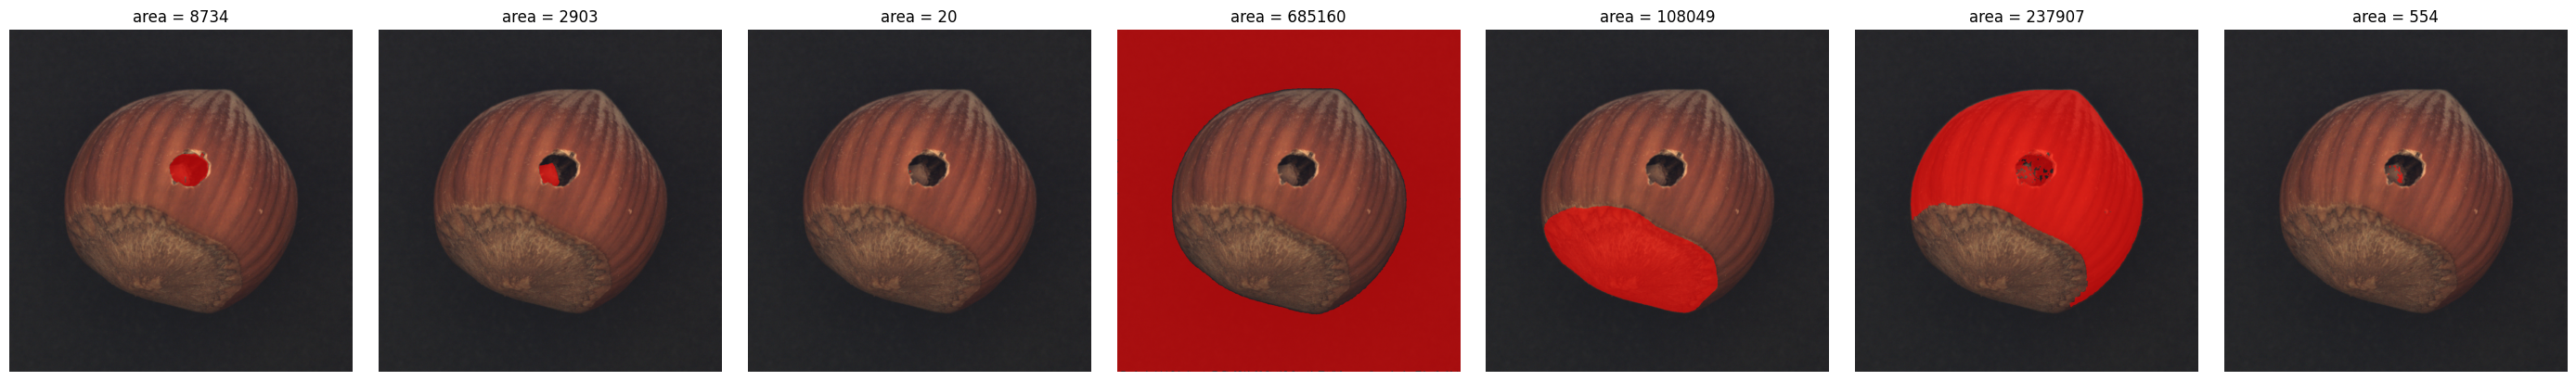

In [5]:
IMG_PATH = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole/004.png")

bgr = cv2.imread(str(IMG_PATH))
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
masks = mask_gen.generate(rgb)
print(f"추출된 마스크 개수: {len(masks)}")

if masks:
    h, w = masks[0]["segmentation"].shape
    print(f"Mask resolution: {h} × {w}")

n = len(masks)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
if n == 1:
    axes = [axes]  

alpha = 0.6
red   = np.array([255, 0, 0], dtype=np.uint8)

for ax, m in zip(axes, masks):
    seg      = m["segmentation"]
    canvas   = rgb.copy()
    canvas[seg] = ((1 - alpha) * canvas[seg] + alpha * red).astype(np.uint8)

    ax.imshow(canvas)
    ax.set_title(f"area = {m['area']}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# # Hazelnut(hole) Mask Token

In [1]:
import cv2, torch, inspect, json, numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from transformers import SiglipVisionModel, SiglipImageProcessor

ROOT_IMG = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole")
SAVE_DIR = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/hole")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

DEV          = "cuda" if torch.cuda.is_available() else "cpu"
PATCH, GRID  = 14, 27                              
MODEL_ID     = "google/siglip-so400m-patch14-384"

In [2]:
class SiglipSubsetWrapper(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        v, e = base.vision_model, base.vision_model.embeddings
        self.patch_proj = getattr(e, "patch_embeddings", None) or e.patch_embedding

        raw_pos = getattr(e, "position_embeddings", None) or e.position_embedding
        pos     = raw_pos.weight if isinstance(raw_pos, torch.nn.Embedding) else raw_pos
        pos     = pos.squeeze(0) if pos.dim() == 3 else pos           
        self.register_buffer("pos_full", pos, persistent=False)

        self.blocks   = v.encoder.layers
        self.ln_post  = v.post_layernorm
        self.need_mask = "attention_mask" in inspect.signature(self.blocks[0].forward).parameters

    def forward(self, pix: torch.Tensor, patch_idx: np.ndarray):
        if len(patch_idx) == 0:
            raise ValueError("empty patch index")      
        idx = torch.as_tensor(patch_idx, device=pix.device, dtype=torch.long)
        x   = self.patch_proj(pix).flatten(2).transpose(1, 2)        
        x   = x.index_select(1, idx) + self.pos_full.index_select(0, idx)
        for blk in self.blocks:
            x = blk(x, attention_mask=None)[0] if self.need_mask else blk(x)[0]
        return self.ln_post(x).squeeze(0)                             

In [ ]:
sam = build_sam2("configs/sam2.1/sam2.1_hiera_l.yaml",
                 "./checkpoints/sam2.1_hiera_large.pt").to(DEV).eval()

mask_gen = SAM2AutomaticMaskGenerator(
    model=sam,
    points_per_side=48, pred_iou_thresh=0.70, stability_score_thresh=0.60,
    mask_threshold=0.60, box_nms_thresh=0.65, crop_n_layers=1,
    crop_overlap_ratio=0.2, min_mask_region_area=500,
    output_mode="binary_mask", multimask_output=True
)

proc   = SiglipImageProcessor.from_pretrained(MODEL_ID)
base   = SiglipVisionModel.from_pretrained(MODEL_ID).to(DEV).eval()
subset = SiglipSubsetWrapper(base).to(DEV).eval()

In [ ]:
def mask_to_idx(mask_bin: np.ndarray) -> np.ndarray:
    pil_mask_rgb = Image.fromarray(mask_bin.astype("uint8") * 255).convert("RGB")

    mask_pix = proc(
        images=[pil_mask_rgb],
        return_tensors="pt",
        do_rescale=False,  
        do_normalize=False  
    )
    mask_bin_384 = (mask_pix["pixel_values"][0, 0] > 0).numpy()     

    mask_bin_378 = mask_bin_384[:GRID*PATCH, :GRID*PATCH]          

    grid = mask_bin_378.reshape(GRID, PATCH, GRID, PATCH).any((1, 3))
    return np.flatnonzero(grid)                                    

img_paths = sorted(ROOT_IMG.glob("*.png"))
for img_path in tqdm(img_paths, desc="hazelnut / hole", unit="img"):
    rgb   = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    masks = mask_gen.generate(rgb)
    if not masks:                         
        continue

    pix = proc(images=Image.fromarray(rgb), return_tensors="pt")["pixel_values"].to(DEV)

    tok_list, seg_list = [], []
    for m in masks:
        idx = mask_to_idx(m["segmentation"])
        if len(idx) == 0:                
            continue
        hid = subset(pix, idx)        
        tok = torch.nn.functional.normalize(hid.mean(0), dim=0).cpu()
        tok_list.append(tok)
        seg_list.append(m["segmentation"].astype("uint8"))

    if tok_list:                         
        torch.save(
            {
                "img_name": img_path.name,
                "mask_token": torch.stack(tok_list),   
                "mask": seg_list                       
            },
            SAVE_DIR / f"{img_path.stem}_siglip_tokens.pt"
        )

# # Hole 이외 Mask Token 생성

## ## Crack

In [1]:
import cv2, torch, inspect, json, numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from transformers import SiglipVisionModel, SiglipImageProcessor

ROOT_IMG = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/crack")
SAVE_DIR = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/crack")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

DEV          = "cuda" if torch.cuda.is_available() else "cpu"
PATCH, GRID  = 14, 27                              
MODEL_ID     = "google/siglip-so400m-patch14-384"

In [2]:
class SiglipSubsetWrapper(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        v, e = base.vision_model, base.vision_model.embeddings
        self.patch_proj = getattr(e, "patch_embeddings", None) or e.patch_embedding

        raw_pos = getattr(e, "position_embeddings", None) or e.position_embedding
        pos     = raw_pos.weight if isinstance(raw_pos, torch.nn.Embedding) else raw_pos
        pos     = pos.squeeze(0) if pos.dim() == 3 else pos           
        self.register_buffer("pos_full", pos, persistent=False)

        self.blocks   = v.encoder.layers
        self.ln_post  = v.post_layernorm
        self.need_mask = "attention_mask" in inspect.signature(self.blocks[0].forward).parameters

    def forward(self, pix: torch.Tensor, patch_idx: np.ndarray):
        if len(patch_idx) == 0:
            raise ValueError("empty patch index")      
        idx = torch.as_tensor(patch_idx, device=pix.device, dtype=torch.long)
        x   = self.patch_proj(pix).flatten(2).transpose(1, 2)         
        x   = x.index_select(1, idx) + self.pos_full.index_select(0, idx)
        for blk in self.blocks:
            x = blk(x, attention_mask=None)[0] if self.need_mask else blk(x)[0]
        return self.ln_post(x).squeeze(0)                             

In [ ]:
sam = build_sam2("configs/sam2.1/sam2.1_hiera_l.yaml",
                 "./checkpoints/sam2.1_hiera_large.pt").to(DEV).eval()

mask_gen = SAM2AutomaticMaskGenerator(
    model=sam,
    points_per_side=48, pred_iou_thresh=0.70, stability_score_thresh=0.60,
    mask_threshold=0.60, box_nms_thresh=0.65, crop_n_layers=1,
    crop_overlap_ratio=0.2, min_mask_region_area=500,
    output_mode="binary_mask", multimask_output=True
)

proc   = SiglipImageProcessor.from_pretrained(MODEL_ID)
base   = SiglipVisionModel.from_pretrained(MODEL_ID).to(DEV).eval()
subset = SiglipSubsetWrapper(base).to(DEV).eval()

In [ ]:
def mask_to_idx(mask_bin: np.ndarray) -> np.ndarray:
    pil_mask_rgb = Image.fromarray(mask_bin.astype("uint8") * 255).convert("RGB")

    mask_pix = proc(
        images=[pil_mask_rgb],
        return_tensors="pt",
        do_rescale=False,   
        do_normalize=False  
    )
    mask_bin_384 = (mask_pix["pixel_values"][0, 0] > 0).numpy()   

    mask_bin_378 = mask_bin_384[:GRID*PATCH, :GRID*PATCH]          

    grid = mask_bin_378.reshape(GRID, PATCH, GRID, PATCH).any((1, 3))
    return np.flatnonzero(grid)                                    

img_paths = sorted(ROOT_IMG.glob("*.png"))
for img_path in tqdm(img_paths, desc="hazelnut / crack", unit="img"):
    rgb   = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    masks = mask_gen.generate(rgb)
    if not masks:                      
        continue

    pix = proc(images=Image.fromarray(rgb), return_tensors="pt")["pixel_values"].to(DEV)

    tok_list, seg_list = [], []
    for m in masks:
        idx = mask_to_idx(m["segmentation"])
        if len(idx) == 0:                
            continue
        hid = subset(pix, idx)           
        tok = torch.nn.functional.normalize(hid.mean(0), dim=0).cpu()
        tok_list.append(tok)
        seg_list.append(m["segmentation"].astype("uint8"))

    if tok_list:                          
        torch.save(
            {
                "img_name": img_path.name,
                "mask_token": torch.stack(tok_list),  
                "mask": seg_list                     
            },
            SAVE_DIR / f"{img_path.stem}_siglip_tokens.pt"
        )

## ## Cut

In [1]:
import cv2, torch, inspect, json, numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from transformers import SiglipVisionModel, SiglipImageProcessor

ROOT_IMG = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/cut")
SAVE_DIR = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/cut")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

DEV          = "cuda" if torch.cuda.is_available() else "cpu"
PATCH, GRID  = 14, 27                     
MODEL_ID     = "google/siglip-so400m-patch14-384"

In [2]:
class SiglipSubsetWrapper(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        v, e = base.vision_model, base.vision_model.embeddings
        self.patch_proj = getattr(e, "patch_embeddings", None) or e.patch_embedding

        raw_pos = getattr(e, "position_embeddings", None) or e.position_embedding
        pos     = raw_pos.weight if isinstance(raw_pos, torch.nn.Embedding) else raw_pos
        pos     = pos.squeeze(0) if pos.dim() == 3 else pos           
        self.register_buffer("pos_full", pos, persistent=False)

        self.blocks   = v.encoder.layers
        self.ln_post  = v.post_layernorm
        self.need_mask = "attention_mask" in inspect.signature(self.blocks[0].forward).parameters

    def forward(self, pix: torch.Tensor, patch_idx: np.ndarray):
        if len(patch_idx) == 0:
            raise ValueError("empty patch index")      
        idx = torch.as_tensor(patch_idx, device=pix.device, dtype=torch.long)
        x   = self.patch_proj(pix).flatten(2).transpose(1, 2)         
        x   = x.index_select(1, idx) + self.pos_full.index_select(0, idx)
        for blk in self.blocks:
            x = blk(x, attention_mask=None)[0] if self.need_mask else blk(x)[0]
        return self.ln_post(x).squeeze(0)                             

In [3]:
sam = build_sam2("configs/sam2.1/sam2.1_hiera_l.yaml",
                 "./checkpoints/sam2.1_hiera_large.pt").to(DEV).eval()

mask_gen = SAM2AutomaticMaskGenerator(
    model=sam,
    points_per_side=48, pred_iou_thresh=0.70, stability_score_thresh=0.60,
    mask_threshold=0.60, box_nms_thresh=0.65, crop_n_layers=1,
    crop_overlap_ratio=0.2, min_mask_region_area=500,
    output_mode="binary_mask", multimask_output=True
)

proc   = SiglipImageProcessor.from_pretrained(MODEL_ID)
base   = SiglipVisionModel.from_pretrained(MODEL_ID).to(DEV).eval()
subset = SiglipSubsetWrapper(base).to(DEV).eval()

In [ ]:
def mask_to_idx(mask_bin: np.ndarray) -> np.ndarray:
    pil_mask_rgb = Image.fromarray(mask_bin.astype("uint8") * 255).convert("RGB")

    mask_pix = proc(
        images=[pil_mask_rgb],
        return_tensors="pt",
        do_rescale=False,   
        do_normalize=False  
    )
    mask_bin_384 = (mask_pix["pixel_values"][0, 0] > 0).numpy()   

    mask_bin_378 = mask_bin_384[:GRID*PATCH, :GRID*PATCH]          

    grid = mask_bin_378.reshape(GRID, PATCH, GRID, PATCH).any((1, 3))
    return np.flatnonzero(grid)                                    

img_paths = sorted(ROOT_IMG.glob("*.png"))
for img_path in tqdm(img_paths, desc="hazelnut / crack", unit="img"):
    rgb   = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    masks = mask_gen.generate(rgb)
    if not masks:                      
        continue

    pix = proc(images=Image.fromarray(rgb), return_tensors="pt")["pixel_values"].to(DEV)

    tok_list, seg_list = [], []
    for m in masks:
        idx = mask_to_idx(m["segmentation"])
        if len(idx) == 0:                
            continue
        hid = subset(pix, idx)           
        tok = torch.nn.functional.normalize(hid.mean(0), dim=0).cpu()
        tok_list.append(tok)
        seg_list.append(m["segmentation"].astype("uint8"))

    if tok_list:                          
        torch.save(
            {
                "img_name": img_path.name,
                "mask_token": torch.stack(tok_list),  
                "mask": seg_list                     
            },
            SAVE_DIR / f"{img_path.stem}_siglip_tokens.pt"
        )

## ## Print

In [1]:
import cv2, torch, inspect, json, numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from transformers import SiglipVisionModel, SiglipImageProcessor

ROOT_IMG = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/print")
SAVE_DIR = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_mask_token/hazelnut/print")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

DEV          = "cuda" if torch.cuda.is_available() else "cpu"
PATCH, GRID  = 14, 27                            
MODEL_ID     = "google/siglip-so400m-patch14-384"

In [2]:
class SiglipSubsetWrapper(torch.nn.Module):
    def __init__(self, base):
        super().__init__()
        v, e = base.vision_model, base.vision_model.embeddings
        self.patch_proj = getattr(e, "patch_embeddings", None) or e.patch_embedding

        raw_pos = getattr(e, "position_embeddings", None) or e.position_embedding
        pos     = raw_pos.weight if isinstance(raw_pos, torch.nn.Embedding) else raw_pos
        pos     = pos.squeeze(0) if pos.dim() == 3 else pos           
        self.register_buffer("pos_full", pos, persistent=False)

        self.blocks   = v.encoder.layers
        self.ln_post  = v.post_layernorm
        self.need_mask = "attention_mask" in inspect.signature(self.blocks[0].forward).parameters

    def forward(self, pix: torch.Tensor, patch_idx: np.ndarray):
        if len(patch_idx) == 0:
            raise ValueError("empty patch index")      
        idx = torch.as_tensor(patch_idx, device=pix.device, dtype=torch.long)
        x   = self.patch_proj(pix).flatten(2).transpose(1, 2)         
        x   = x.index_select(1, idx) + self.pos_full.index_select(0, idx)
        for blk in self.blocks:
            x = blk(x, attention_mask=None)[0] if self.need_mask else blk(x)[0]
        return self.ln_post(x).squeeze(0)                             

In [3]:
sam = build_sam2("configs/sam2.1/sam2.1_hiera_l.yaml",
                 "./checkpoints/sam2.1_hiera_large.pt").to(DEV).eval()

mask_gen = SAM2AutomaticMaskGenerator(
    model=sam,
    points_per_side=48, pred_iou_thresh=0.70, stability_score_thresh=0.60,
    mask_threshold=0.60, box_nms_thresh=0.65, crop_n_layers=1,
    crop_overlap_ratio=0.2, min_mask_region_area=500,
    output_mode="binary_mask", multimask_output=True
)

proc   = SiglipImageProcessor.from_pretrained(MODEL_ID)
base   = SiglipVisionModel.from_pretrained(MODEL_ID).to(DEV).eval()
subset = SiglipSubsetWrapper(base).to(DEV).eval()

In [ ]:
def mask_to_idx(mask_bin: np.ndarray) -> np.ndarray:
    pil_mask_rgb = Image.fromarray(mask_bin.astype("uint8") * 255).convert("RGB")

    mask_pix = proc(
        images=[pil_mask_rgb],
        return_tensors="pt",
        do_rescale=False,   
        do_normalize=False  
    )
    mask_bin_384 = (mask_pix["pixel_values"][0, 0] > 0).numpy()   

    mask_bin_378 = mask_bin_384[:GRID*PATCH, :GRID*PATCH]          

    grid = mask_bin_378.reshape(GRID, PATCH, GRID, PATCH).any((1, 3))
    return np.flatnonzero(grid)                                    

img_paths = sorted(ROOT_IMG.glob("*.png"))
for img_path in tqdm(img_paths, desc="hazelnut / crack", unit="img"):
    rgb   = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    masks = mask_gen.generate(rgb)
    if not masks:                      
        continue

    pix = proc(images=Image.fromarray(rgb), return_tensors="pt")["pixel_values"].to(DEV)

    tok_list, seg_list = [], []
    for m in masks:
        idx = mask_to_idx(m["segmentation"])
        if len(idx) == 0:                
            continue
        hid = subset(pix, idx)           
        tok = torch.nn.functional.normalize(hid.mean(0), dim=0).cpu()
        tok_list.append(tok)
        seg_list.append(m["segmentation"].astype("uint8"))

    if tok_list:                          
        torch.save(
            {
                "img_name": img_path.name,
                "mask_token": torch.stack(tok_list),  
                "mask": seg_list                     
            },
            SAVE_DIR / f"{img_path.stem}_siglip_tokens.pt"
        )